In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from utils import evaluate_model
from constants import (
    driver_behavior,
    vehicle_attributes,
    driver_attributes,
    driver_navigation,
    gis_attributes,
    record_day,
    target_mro,
)

In [2]:
model_path = "./Out/mro_model_4_month_best.txt"
model = lgb.Booster(model_file=model_path)

In [3]:
importances = model.feature_importance()
feature_names = model.feature_name()

# put feature names and importances into a DataFrame
feature_importance_df = pd.DataFrame(
    {"feature": feature_names, "importance": importances}
)

feature_groups = [
    ["est_hh_incm_prmr_cd"],
    ["purchaser_age_at_tm_of_purch"],
    ["input_indiv_gndr_prmr_cd"],
    ["umf_xref_finc_gbl_trim"],
    ["engn_size"],
    ["purchase_time"],
    ["tavg_1", "tavg_2", "tavg_3", "tavg_4"],
    [
        "random_avg_traffic_1",
        "random_avg_traffic_2",
        "random_avg_traffic_3",
        "random_avg_traffic_4",
    ],
    ["hard_braking_1", "hard_braking_2", "hard_braking_3", "hard_braking_4"],
    [
        "hard_acceleration_1",
        "hard_acceleration_2",
        "hard_acceleration_3",
        "hard_acceleration_4",
    ],
    ["speeding_sum_1", "speeding_sum_2", "speeding_sum_3", "speeding_sum_4"],
    ["day_mileage_1", "day_mileage_2", "day_mileage_3", "day_mileage_4"],
    ["mro_prev"],
]

group_feature_names = [
    "Income",
    "Age",
    "Gender",
    "Trim",
    "Engine Size",
    "Purchase Time",
    "Temperature",
    "Traffic",
    "Hard Braking",
    "Hard Acceleration",
    "Speeding",
    "Mileage",
    "MRO Previous",
]

# caclulate the mean importance for each group
group_importances = []
for group in feature_groups:
    group_importance = np.mean([importances[feature_names.index(f)] for f in group])
    group_importances.append(group_importance)


# group_importances
# create a DataFrame with the group names and importances
group_importance_df = pd.DataFrame(
    {"feature": group_feature_names, "importance": group_importances}
)

In [4]:
feature_importance_df

,feature,importance
0,est_hh_incm_prmr_cd,254
1,purchaser_age_at_tm_of_purch,611
2,input_indiv_gndr_prmr_cd,43
3,umf_xref_finc_gbl_trim,241
4,engn_size,703
5,purchase_time,2624
6,hard_braking_1,534
7,hard_acceleration_1,509
8,speeding_sum_1,702
9,day_mileage_1,1310


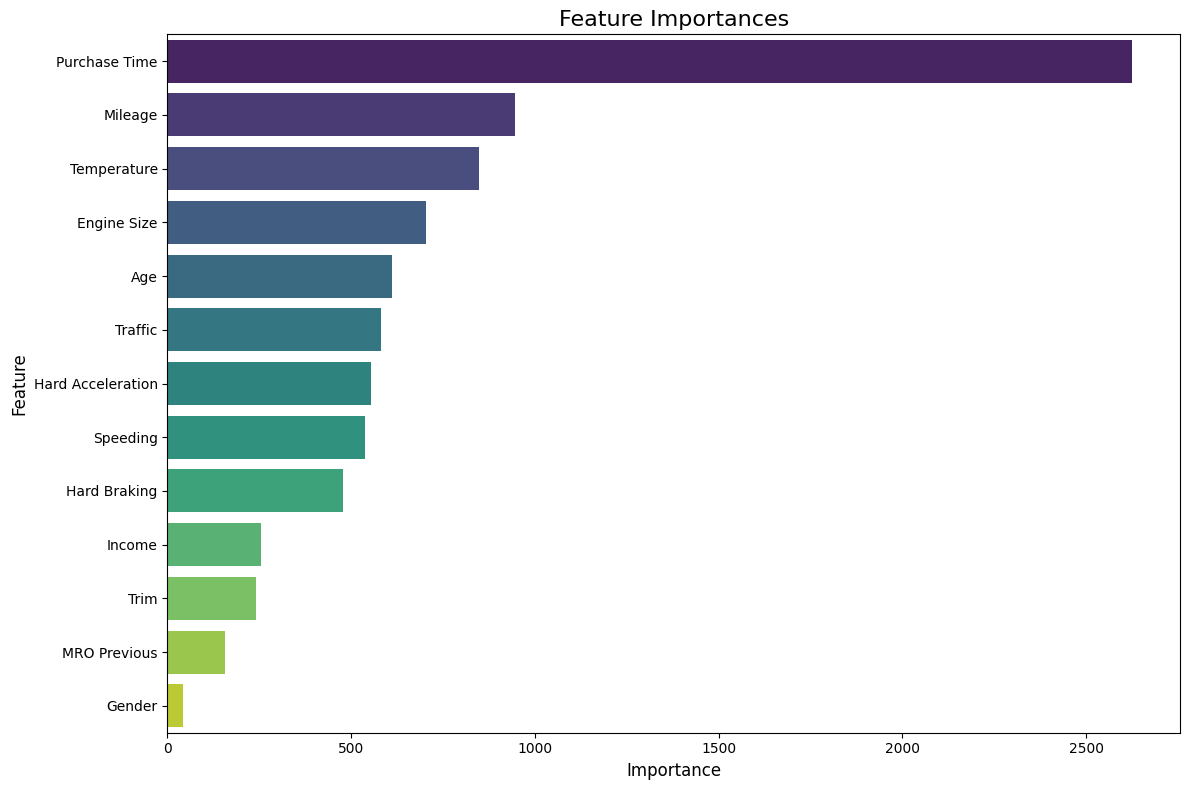

In [5]:
# group_importance_df
# plot the feature importances with seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.barplot(
    x="importance",
    y="feature",
    hue="feature",
    data=group_importance_df.sort_values(by="importance", ascending=False),
    # data=group_importance_df,
    palette="viridis",  # Changed palette to 'viridis'
)
plt.title("Feature Importances", fontsize=16)  # Increased title fontsize
plt.xlabel("Importance", fontsize=12)  # Increased xlabel fontsize
plt.ylabel("Feature", fontsize=12)  # Increased ylabel fontsize
plt.xticks(fontsize=10)  # Adjusted x ticks fontsize
plt.yticks(fontsize=10)  # Adjusted y ticks fontsize
plt.tight_layout()
# plt.savefig("./Out/mro_model_4_month_feature_importance.png")
plt.show()

In [6]:
file_name = "./Data/mro_daily_clean.csv"
data = pd.read_csv(file_name, index_col=0, engine="pyarrow")


selected_columns = (
    driver_navigation
    + driver_behavior
    + vehicle_attributes
    + driver_attributes
    + gis_attributes
    + record_day
    + target_mro
)

data = data[selected_columns]


data["purchase_time"] = (
    data["purchase_yr_nbr"].astype(int).astype(str)
    + "_"
    + data["purchase_mth_nbr"].astype(int).astype(str)
)


data = data[data["record_days"] >= 120]
data = data.drop(["purchase_yr_nbr", "purchase_mth_nbr"], axis=1)

In [7]:
time_window = 4
data_Sierra_LD = data[data["gmqualty_model"] == "Sierra LD"]
data_Sierra_LD.reset_index(inplace=True, drop=True)

# add the features to the data_Sierra_LD
for i in range(1, time_window + 1):
    data_Sierra_LD[f"hard_braking_{i}"] = data_Sierra_LD.groupby("id")[
        "hard_braking"
    ].transform(lambda x: x.shift(i))
    data_Sierra_LD[f"hard_acceleration_{i}"] = data_Sierra_LD.groupby("id")[
        "hard_acceleration"
    ].transform(lambda x: x.shift(i))
    data_Sierra_LD[f"speeding_sum_{i}"] = data_Sierra_LD.groupby("id")[
        "speeding_sum"
    ].transform(lambda x: x.shift(i))
    data_Sierra_LD[f"day_mileage_{i}"] = data_Sierra_LD.groupby("id")[
        "day_mileage"
    ].transform(lambda x: x.shift(i))
    data_Sierra_LD[f"tavg_{i}"] = data_Sierra_LD.groupby("id")["tavg"].transform(
        lambda x: x.shift(i)
    )
    data_Sierra_LD[f"random_avg_traffic_{i}"] = data_Sierra_LD.groupby("id")[
        "random_avg_traffic"
    ].transform(lambda x: x.shift(i))

data_Sierra_LD["mro_prev"] = data_Sierra_LD.groupby("id")["mro"].transform(
    lambda x: x.shift(1)
)

data_Sierra_LD

/tmp/ipykernel_188824/2272755720.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Sierra_LD[f"hard_braking_{i}"] = data_Sierra_LD.groupby("id")[
/tmp/ipykernel_188824/2272755720.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Sierra_LD[f"hard_acceleration_{i}"] = data_Sierra_LD.groupby("id")[
/tmp/ipykernel_188824/2272755720.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,id,yr_nbr,mth_nbr,week_nbr,hard_braking,hard_acceleration,speeding_sum,day_mileage,gmqualty_model,umf_xref_finc_gbl_trim,...,day_mileage_3,tavg_3,random_avg_traffic_3,hard_braking_4,hard_acceleration_4,speeding_sum_4,day_mileage_4,tavg_4,random_avg_traffic_4,mro_prev
0,wpvCrMOHw4PCpMK3wqrCtsKtwrvDhMKXwqvCpsKnwpvCng==,2018,2,6,1,1,3.0,29.687500,Sierra LD,MIDLEVEL_TRIM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,wpvCrMOHw4PCpMK3wqrCtsKtwrvDhMKXwqvCpsKnwpvCng==,2018,2,6,5,0,3.0,38.968750,Sierra LD,MIDLEVEL_TRIM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,wpvCrMOHw4PCpMK3wqrCtsKtwrvDhMKXwqvCpsKnwpvCng==,2018,2,6,15,1,5.0,55.750000,Sierra LD,MIDLEVEL_TRIM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,wpvCrMOHw4PCpMK3wqrCtsKtwrvDhMKXwqvCpsKnwpvCng==,2018,2,6,11,2,4.0,106.921875,Sierra LD,MIDLEVEL_TRIM,...,29.687500,23.100000,610.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,wpvCrMOHw4PCpMK3wqrCtsKtwrvDhMKXwqvCpsKnwpvCng==,2018,2,6,2,1,1.0,52.937500,Sierra LD,MIDLEVEL_TRIM,...,38.968750,23.300000,16925.130000,1.0,1.0,3.0,29.687500,23.100000,610.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6528026,wp3CrMOHw4rCrMKuwqrCt8ONwr7CscKXwqzCpcKlwp3CnQ==,2019,12,52,0,1,0.0,22.953125,Sierra LD,UPLEVEL_TRIM,...,112.203125,11.800000,7212.610000,5.0,3.0,4.0,99.312500,11.000000,21564.570000,0.0
6528027,wp3CrMOHw4rCrMKuwqrCt8ONwr7CscKXwqzCpcKlwp3CnQ==,2019,12,52,6,0,7.0,59.546875,Sierra LD,UPLEVEL_TRIM,...,70.296875,5.300000,21903.860000,8.0,3.0,4.0,112.203125,11.800000,7212.610000,0.0
6528028,wp3CrMOHw4rCrMKuwqrCt8ONwr7CscKXwqzCpcKlwp3CnQ==,2019,12,52,9,6,9.0,103.656250,Sierra LD,UPLEVEL_TRIM,...,40.796875,15.999657,22378.374667,6.0,3.0,4.0,70.296875,5.300000,21903.860000,0.0
6528029,wp3CrMOHw4rCrMKuwqrCt8ONwr7CscKXwqzCpcKlwp3CnQ==,2019,12,52,2,2,4.0,33.406250,Sierra LD,UPLEVEL_TRIM,...,22.953125,16.014132,22368.854164,6.0,1.0,1.0,40.796875,15.999657,22378.374667,0.0


In [8]:
column_full = data_Sierra_LD.columns.values.tolist()
features_remove = [
    "id",
    "yr_nbr",
    "week_nbr",
    "mth_nbr",
    "mro",
    "record_days",
    "gmqualty_model",
    "hard_braking",
    "hard_acceleration",
    "speeding_sum",
    "day_mileage",
    "tavg",
    "random_avg_traffic",
]
features = [item for item in column_full if item not in features_remove]
features

['umf_xref_finc_gbl_trim',
 'engn_size',
 'est_hh_incm_prmr_cd',
 'purchaser_age_at_tm_of_purch',
 'input_indiv_gndr_prmr_cd',
 'purchase_time',
 'hard_braking_1',
 'hard_acceleration_1',
 'speeding_sum_1',
 'day_mileage_1',
 'tavg_1',
 'random_avg_traffic_1',
 'hard_braking_2',
 'hard_acceleration_2',
 'speeding_sum_2',
 'day_mileage_2',
 'tavg_2',
 'random_avg_traffic_2',
 'hard_braking_3',
 'hard_acceleration_3',
 'speeding_sum_3',
 'day_mileage_3',
 'tavg_3',
 'random_avg_traffic_3',
 'hard_braking_4',
 'hard_acceleration_4',
 'speeding_sum_4',
 'day_mileage_4',
 'tavg_4',
 'random_avg_traffic_4',
 'mro_prev']

In [9]:
train_ids, val_ids = train_test_split(
    data_Sierra_LD["id"].unique(), test_size=0.1, random_state=42
)
train_data = data_Sierra_LD[data_Sierra_LD["id"].isin(train_ids)]
val_data = data_Sierra_LD[data_Sierra_LD["id"].isin(val_ids)]

# Check the lengths of the train and validation sets
print("Length of train_ids:", len(train_ids))
print("Length of val_ids:", len(val_ids))

Length of train_ids: 19055
Length of val_ids: 2118


In [10]:
# validation on the Sierra LD with 
X_train = train_data[features]
y_train = train_data[target_mro]
X_valid = val_data[features]
y_valid = val_data[target_mro]
# make sure all object type columns are converted to category
for col in X_train.select_dtypes(include=["object"]).columns:
    X_train[col] = X_train[col].astype("category")
    X_valid[col] = X_valid[col].astype("category")
train_dataset = lgb.Dataset(X_train, label=y_train)
valid_dataset = lgb.Dataset(X_valid, label=y_valid, reference=train_dataset)

# use bst model to predict the Sierra LD
y_pred = model.predict(X_valid)
metrics = evaluate_model(y_valid, y_pred)
print("Precision:", metrics["precision"])
print("Recall:", metrics["recall"])
print("F1 Score:", metrics["f1"])
print("Accuracy:", metrics["accuracy"])
print("AUC:", metrics["auc"])
print("Average Precision:", metrics["average_precision"])
print("Confusion Matrix:\n", metrics["confusion_matrix"])

/tmp/ipykernel_188824/1032834754.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype("category")
/tmp/ipykernel_188824/1032834754.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid[col] = X_valid[col].astype("category")
/tmp/ipykernel_188824/1032834754.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Precision: 0.010060284111257013
Recall: 0.5561788483748556
F1 Score: 0.019763089162545693
Accuracy: 0.49024309562391294
AUC: 0.5211065754127978
Average Precision: 0.010166050735418333
Confusion Matrix:
 [[318227 331709]
 [  2690   3371]]
